# Listening to events

We will download some gravitational wave data from LIGO and play it as a sound.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.signal as ss

from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import gwpy.time

In [111]:
import numpy as np

## GW150914

In [3]:
# get event GPS time
t0 = event_gps("GW150914")

# list of detectors
ifos = ['H1', 'L1']

In [4]:
# specify start and end times
duration_in_seconds = 4096

start_time = int(t0 - 0.5*duration_in_seconds)
end_time = int(t0 + 0.5*duration_in_seconds)

In [5]:
data_dict = {ifo: TimeSeries.fetch_open_data(ifo, start_time, end_time) for ifo in ifos}

Let's look at the raw data.

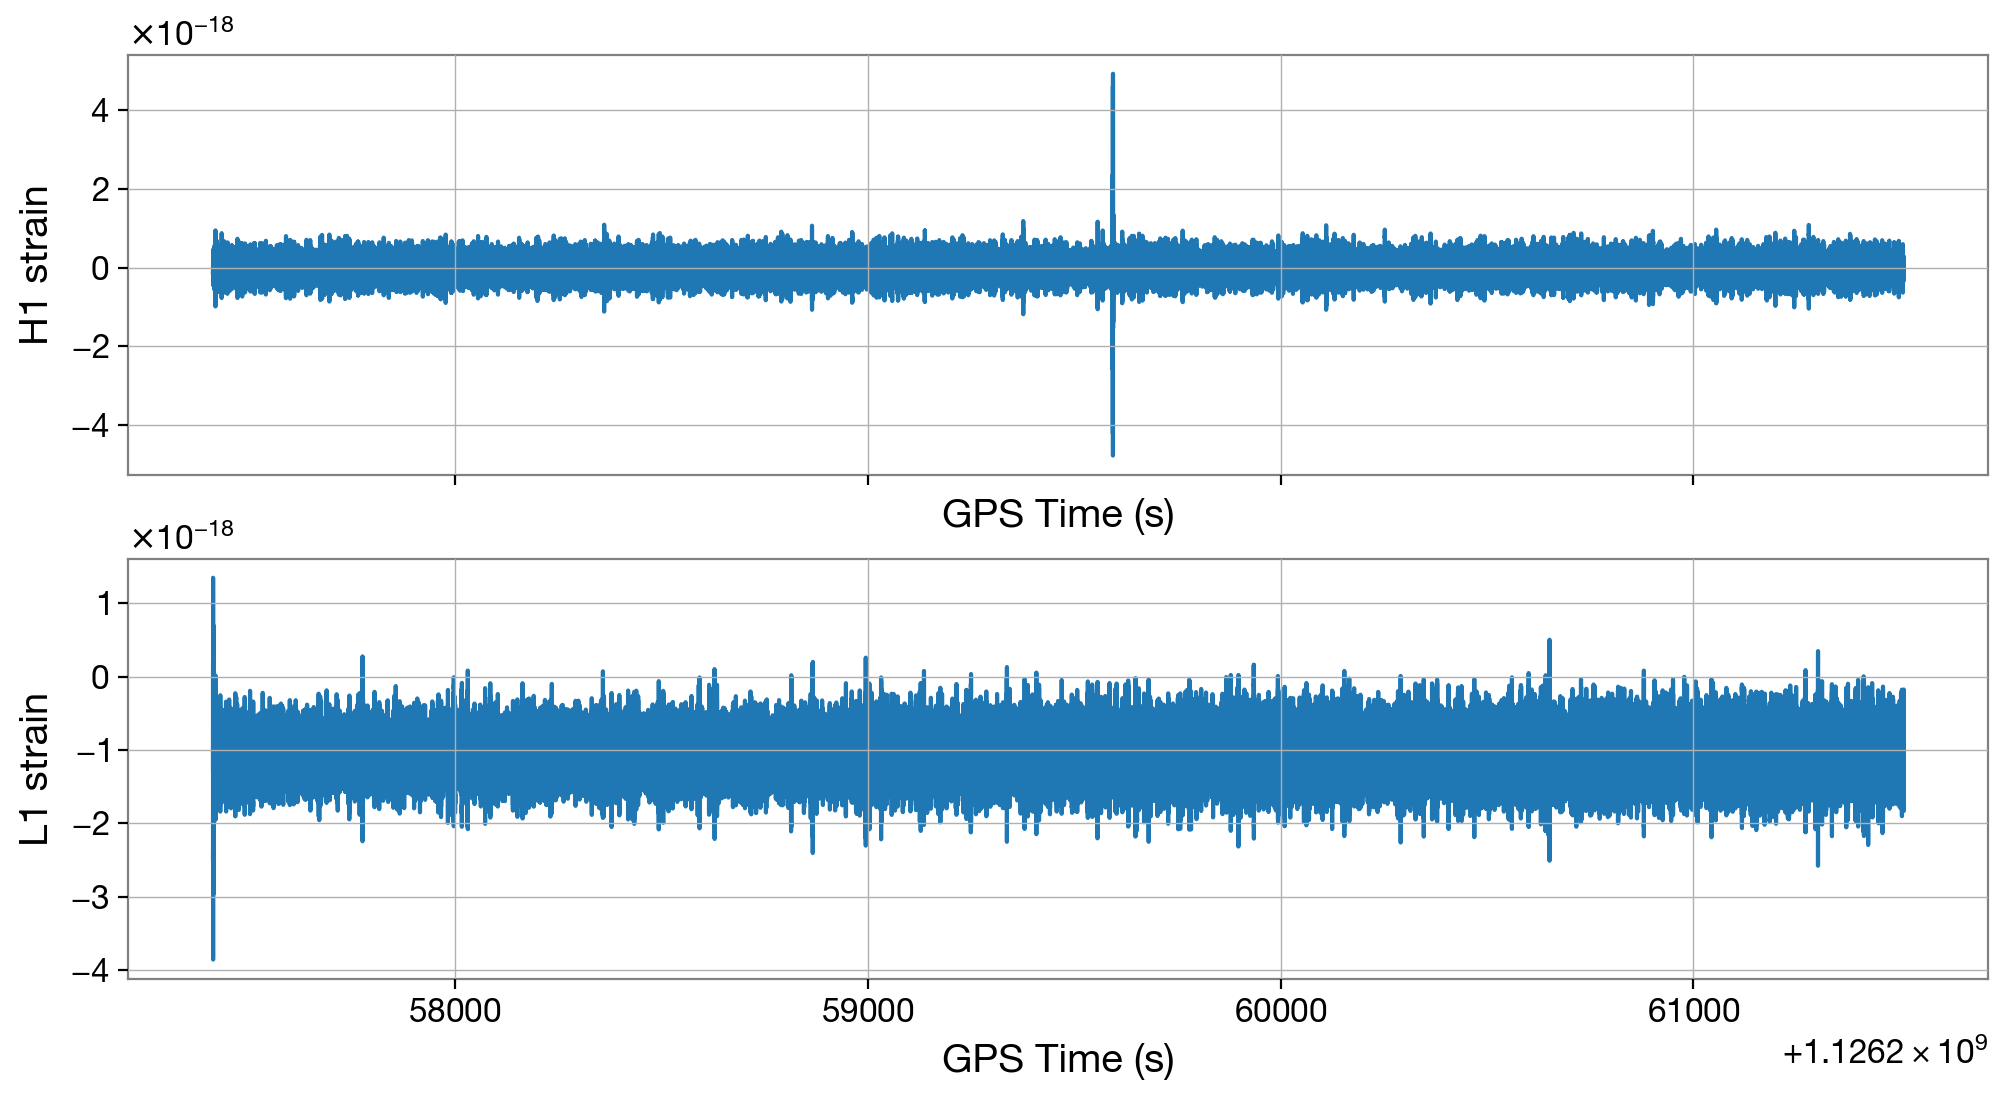

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
for ax, (ifo, data) in zip(axs, data_dict.items()):
    ax.plot(data)
    ax.set_ylabel('{} strain'.format(ifo))
    ax.set_xlabel('GPS Time (s)')

Get a a power spectrum.

In [101]:
# apply a butterwoth bandpass filter to remove low and high frequency noise
flow = 100
fhigh = 400
order = 4

filtered_data_dict = {}
for ifo, data in data_dict.items():
    fny = 0.5*data.sample_rate.value
    b, a = ss.butter(order, [flow/fny, fhigh/fny], btype='bandpass', output='ba')
    filt_data = ss.filtfilt(b, a, data)
    filtered_data_dict[ifo] = TimeSeries(filt_data, t0=data.times[0], dt=data.dt)

In [102]:
psd_dict = {}
for ifo, data in data_dict.items():
    fs = data.sample_rate.value
    freq, psd = ss.welch(data, fs=fs, nperseg=fs*4)
    psd_dict[ifo] = psd

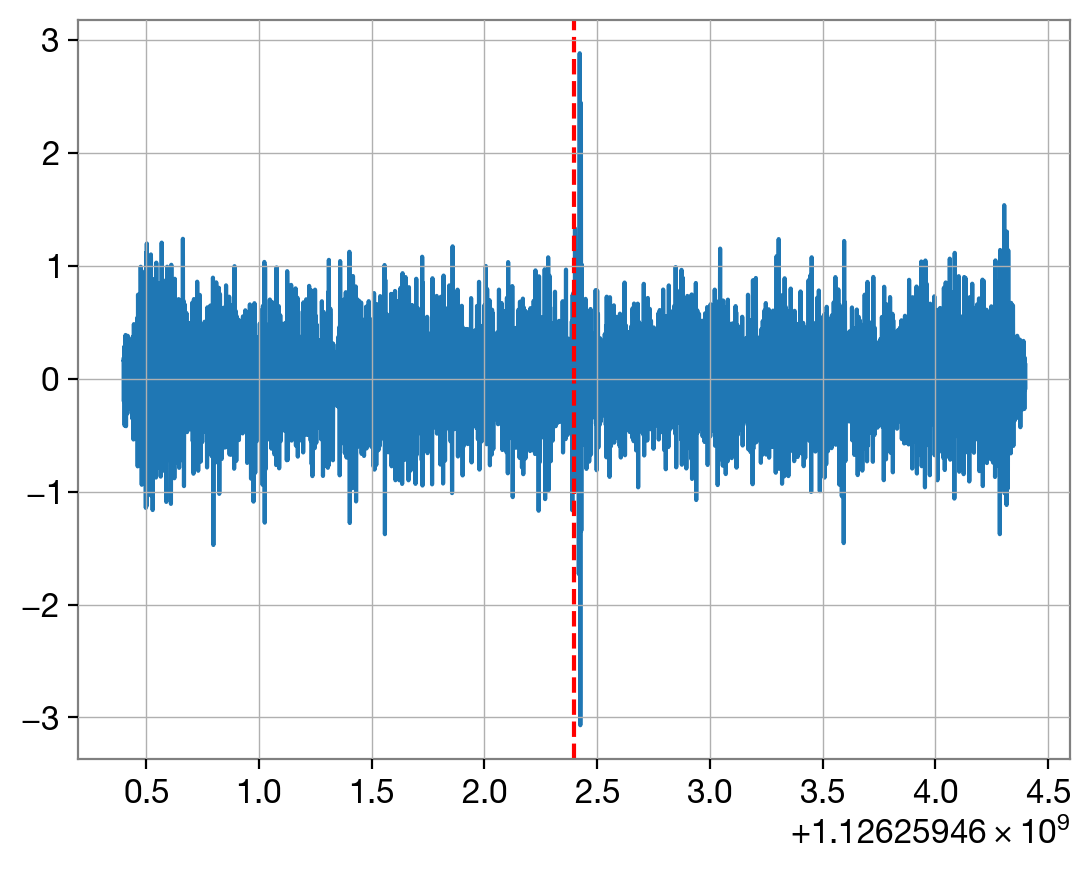

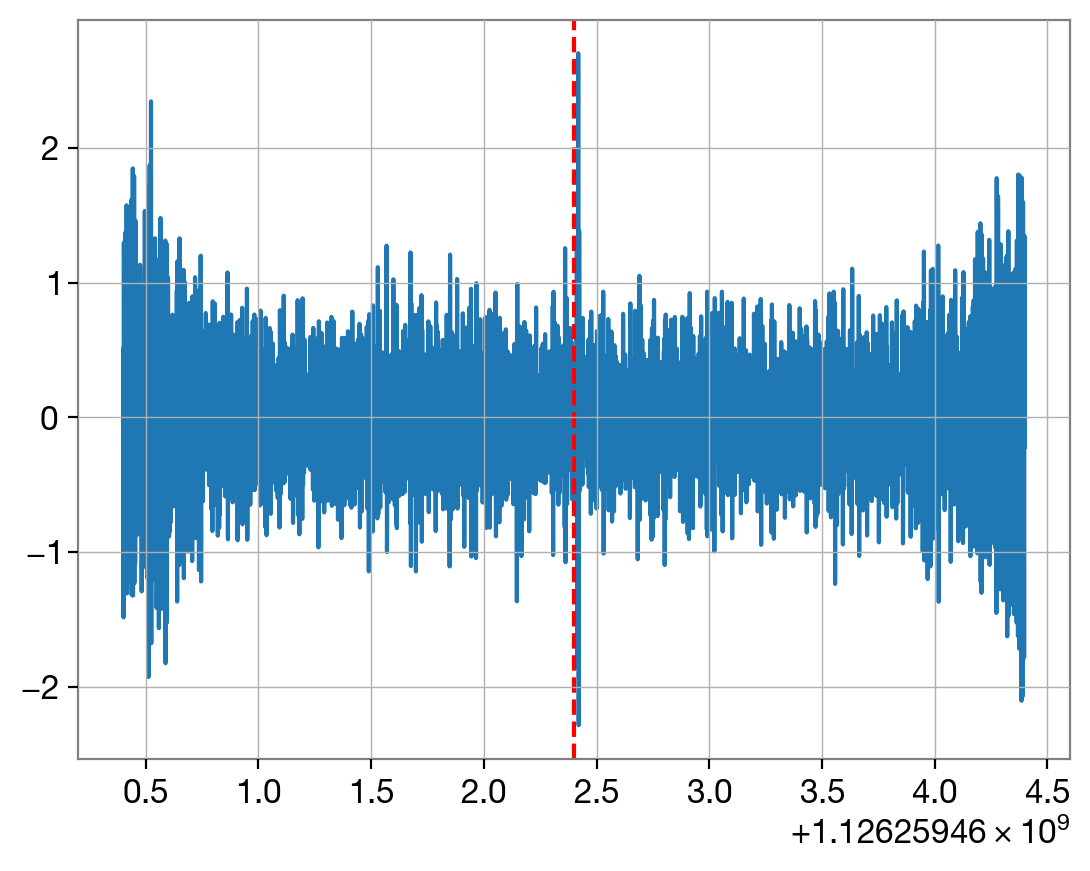

In [103]:
# whiten data
white_data_dict = {}
for ifo, data in filtered_data_dict.items():
    # compute FFT of data
    d = data.crop(t0-2, t0+2)
    dt = d.dt.value
    window = ss.windows.tukey(len(d), alpha=0.05)
    data_fd = np.fft.rfft(d.value*window)
    wd_td = np.fft.irfft(data_fd/np.sqrt(psd_dict[ifo]/dt /2), n=len(d))
    white_data_dict[ifo] = TimeSeries(wd_td, t0=d.times[0], dt=d.dt)
    plt.plot(white_data_dict[ifo] )
    plt.axvline(t0, color='r', ls='--')
    plt.show()


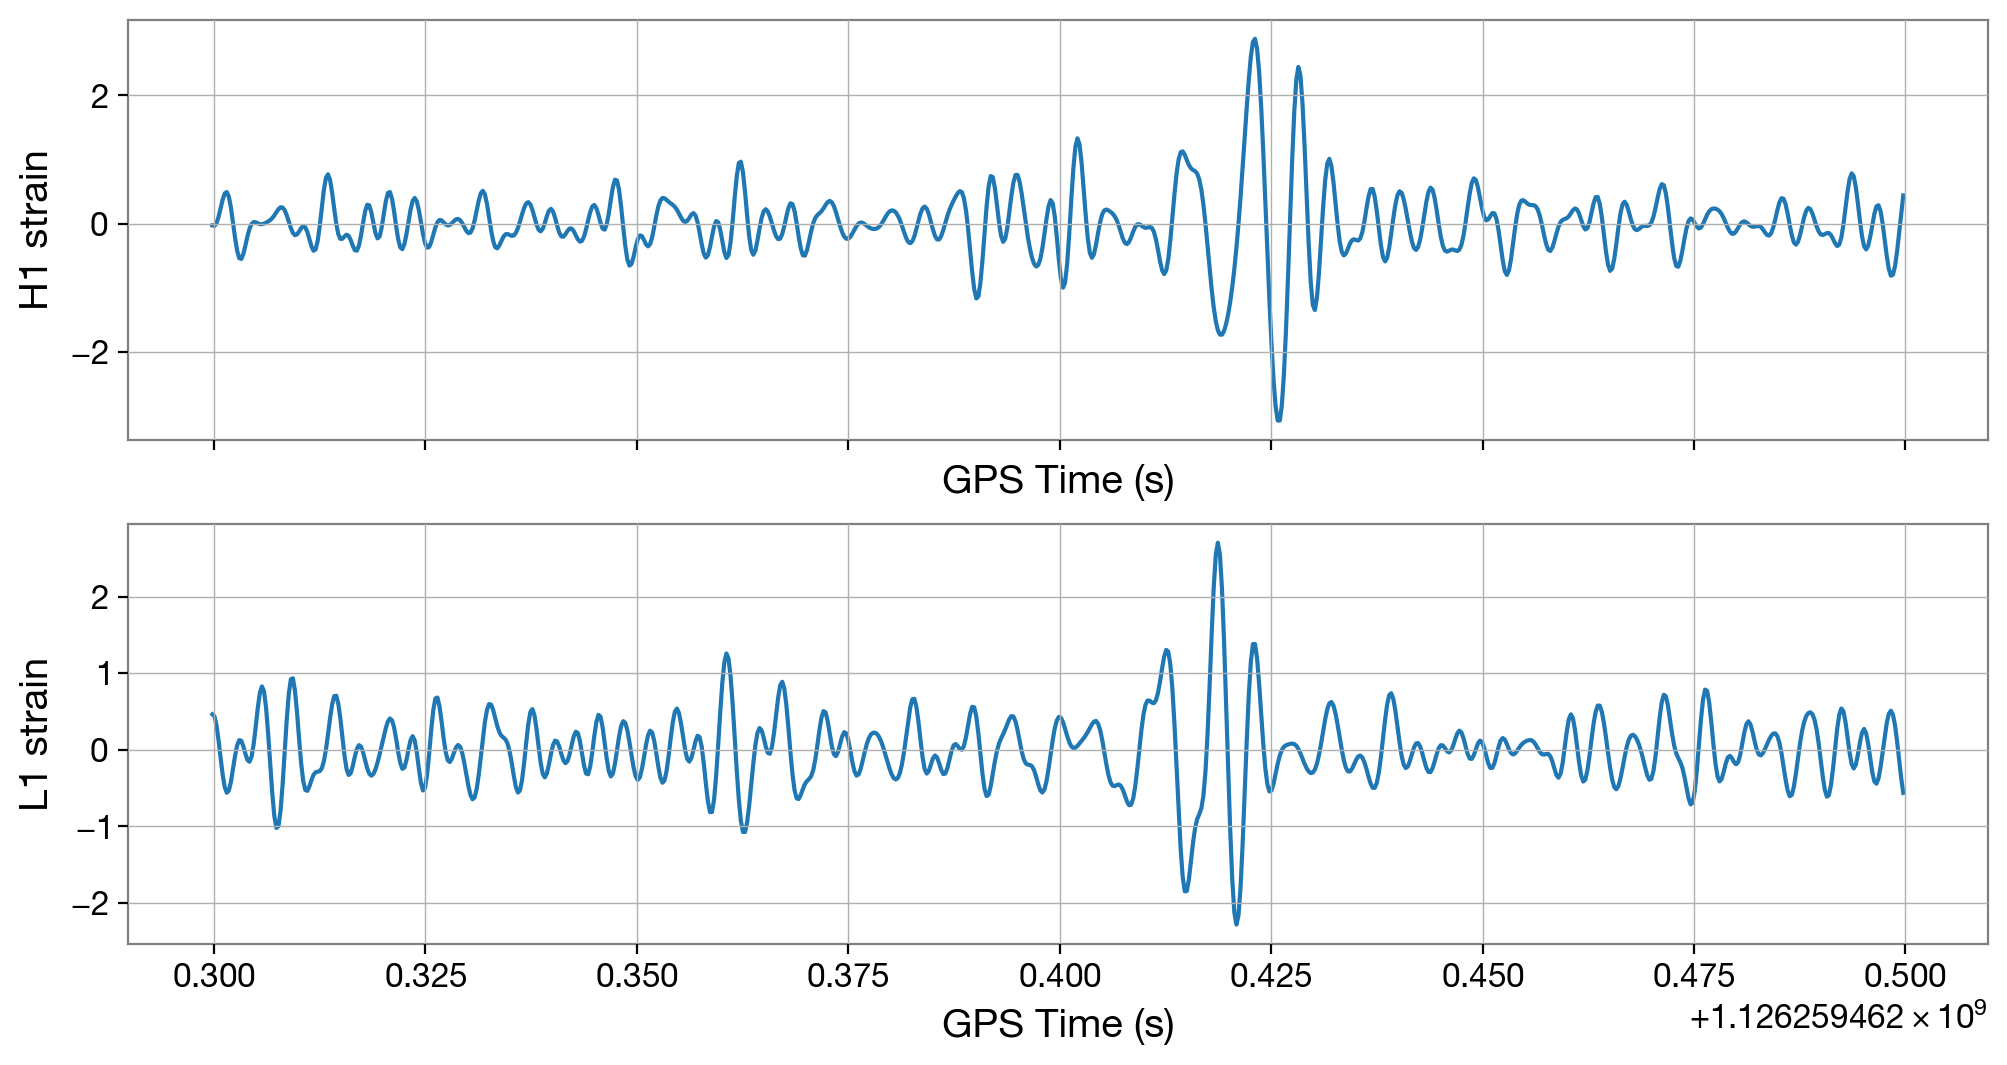

In [104]:
# plot whitened data but only 1s around t0
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
for ax, (ifo, data) in zip(axs, white_data_dict.items()):
    ax.plot(data.crop(t0-0.1, t0+0.1))
    ax.set_ylabel('{} strain'.format(ifo))
    ax.set_xlabel('GPS Time (s)')

That's the signal!

In [105]:
# stored cropped data in a new dict
crop_data_dict = {}
for ifo, data in white_data_dict.items():
    crop_data_dict[ifo] = data.crop(t0-1, t0+1)

In [110]:
# play cropped data as a sound
from IPython.display import Audio

gain_factor = 1
playback_rate = 44100


# Ensure the data is in int16 format for WAV. You might need to scale it appropriately.
d = crop_data_dict['H1'].value
scaled_data = np.int16(d/np.max(np.abs(d)) * 32767)

srate = int(data.sample_rate.value)
playback_rate = srate*1.5
print(f"Increasing srate by {playback_rate/srate:.2f}x from {srate} Hz to {playback_rate} Hz")

audio = Audio(data=scaled_data*gain_factor, rate=playback_rate)
display(audio)

Increasing srate by 1.50x from 4096 Hz to 6144.0 Hz
